In [1]:
import os
import json
import astropy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import Distance
from astropy.cosmology import Planck15
# pd.set_option('display.max_rows', 500)

model='2019'

In [2]:
def absmag(m, z):
    '''
    Converts apparent magnitude to absolute magnitude.
    
    Args:
        m (float): apparent magnitude
        z (float): redshift
    '''
    try:
        z = float(z)
    except ValueError:
        if type(z) == str:
            z = float(z.split('±')[0])
    if m is None or m is np.nan or z is None or z is np.nan:
        return np.nan
    else:
        if z==0:
            M = m
        elif z < 0:
            M = m
        else:
            try:
                d = Distance(unit=u.pc, z=float(z), allow_negative=True)
                M = m - 5 * np.log10(d/(10*u.pc)) + 5
            except:
                M = np.nan
        return M
absmag = np.vectorize(absmag)

In [3]:
import json
import numpy as np
import pandas as pd

from sncosmo.bandpasses import _BANDPASSES
from astropy.time import Time
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import time

import builtins

time_start = time.time()

def loadEvent(filename):
    """
    Reads in lightcurve data from a file and returns data in a dictionary format.
    
    Args:
    - filename (str): Path to lightcurve file
    
    Returns:
    - data (dict): Dictionary containing the lightcurve data from the file. The keys are generally 't' and each of the filters in the file as well as their accompanying error values.
    """
    if filename.endswith(".json"):
        with open(filename) as f:
            data = json.load(f)
            for key in data.keys():
                data[key] = np.array(data[key])
    else:
        lines = [line.rstrip("\n") for line in open(filename)]
        lines = builtins.filter(None, lines)

        sncosmo_filts = [val["name"] for val in _BANDPASSES.get_loaders_metadata()]
        sncosmo_maps = {name: name.replace(":", "_") for name in sncosmo_filts}

        data = {}
        for line in lines:
            lineSplit = line.split(" ")
            lineSplit = list(builtins.filter(None, lineSplit))
            mjd = Time(lineSplit[0], format="isot").mjd
            filt = lineSplit[1]

            if filt in sncosmo_maps:
                filt = sncosmo_maps[filt]

            mag = float(lineSplit[2])
            dmag = float(lineSplit[3])

            if filt not in data:
                data[filt] = np.empty((0, 3), float)
            data[filt] = np.append(data[filt], np.array([[mjd, mag, dmag]]), axis=0)

    return data

def read_lightcurve_file(filename: str):
    """
    Function to read in lightcurve file and create a dictionary containing the time (in days) at which the lightcurves 
    are evaluated and the corresponding values for different filters.
    """
    with open(filename, "r") as f:
        header = list(builtins.filter(None, f.readline().rstrip().strip("#").split(" ")))
    df = pd.read_csv(
        filename,
        delimiter=" ",
        comment="#",
        header=None,
        names=header,
        index_col=False,
    )
    df.rename(columns={"t[days]": "t"}, inplace=True)

    return df#.to_dict(orient="series")


In [4]:
time_start = time.time()
if model == '2019':
    bulla_grid_files = sorted(glob.glob("lcs_bulla_2019/lcs/*.dat"))
    if bulla_grid_files == []:
        bulla_grid_files = sorted(glob.glob("lcs_bulla_2019/*.dat"))
elif model == '2022':
    bulla_grid_files = sorted(glob.glob("lcs_bulla_2022/*.dat"))

# print(bulla_grid_files[0])


# print(type(bulla_grid_files[0]))
# print(len(bulla_grid_files))
bulla_grid_lightcurves = {filename: read_lightcurve_file(filename) for filename in list(bulla_grid_files)}
time_end = time.time()
print(f"Time taken to load lightcurves: {time_end - time_start:.2f} seconds")

Time taken to load lightcurves: 3.45 seconds


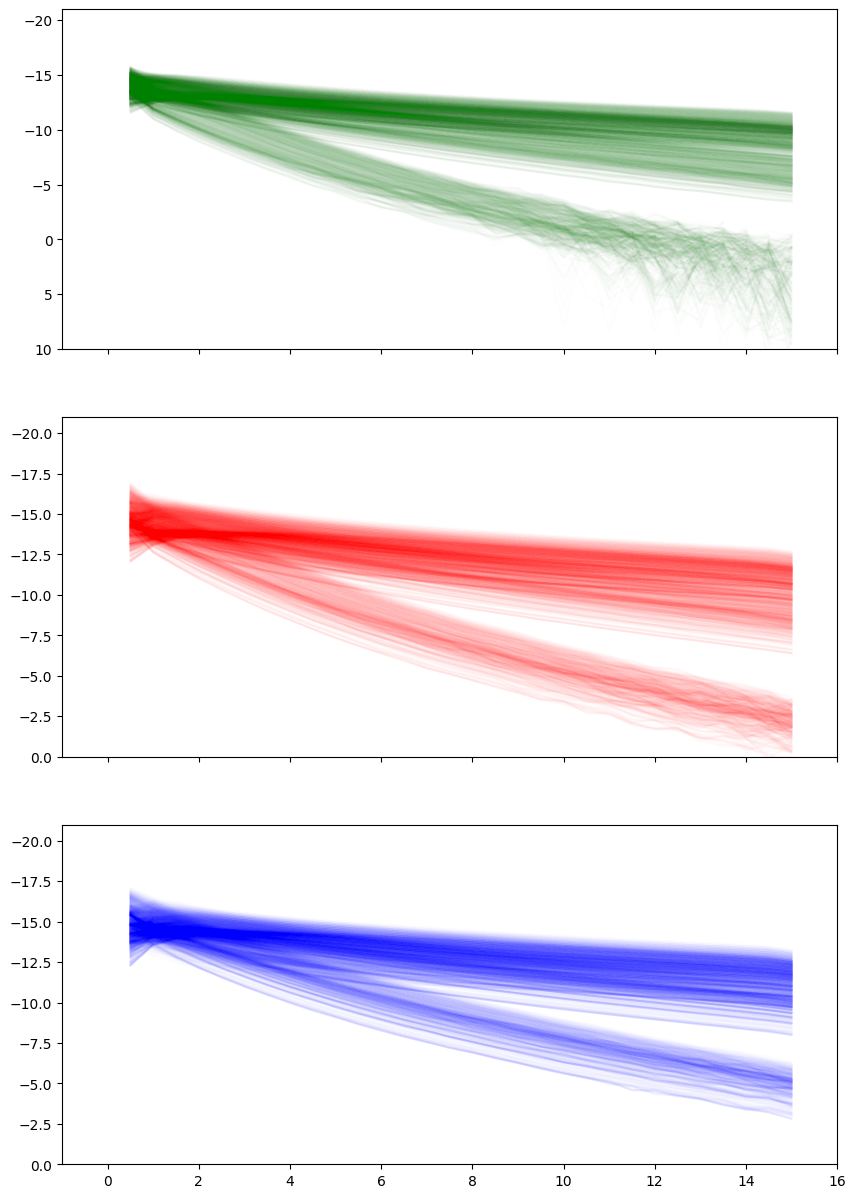

In [5]:
## plot all of the lightcurves in a 3x1 grid where each subplot corresponds to ztfg, ztfr, and ztfi filters
fig, ax = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
[ax[0].plot(value["t"], value["ztfg"], alpha=0.01, color='g') for key, value in bulla_grid_lightcurves.items()]
[ax[1].plot(value["t"], value["ztfr"], alpha=0.01, color='r') for key, value in bulla_grid_lightcurves.items()]
[ax[2].plot(value["t"], value["ztfi"], alpha=0.01, color='b') for key, value in bulla_grid_lightcurves.items()]
ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
[ax[i].set_xlim(-1,16) for i in range(3)];
ax[0].set_ylim(10,-21), ax[1].set_ylim(0,-21), ax[2].set_ylim(0,-21);

In [6]:
def get_peak(lightcurve, filter):
    '''
    Function to return the time of peak brightness and the peak brightness value for a given lightcurve and filter.
    
    Args:
    lightcurve (pd.DataFrame): Lightcurve data
    filter (str): Filter for which to find the peak brightness
    '''
    assert filter in lightcurve.columns, f"Filter {filter} not found in lightcurve data."
    
    max_luminosity_time = lightcurve[lightcurve[filter] == lightcurve[filter].min()]["t"].values[0]
    max_luminosity_value = lightcurve[filter].min()
    
    return max_luminosity_time, max_luminosity_value

def calc_rise(lightcurve, filter):
    '''
    Function to calculate the rise time for a given lightcurve and filter.
    
    Args:
    lightcurve (pd.DataFrame): Lightcurve data
    filter (str): Filter for which to calculate the rise time
    '''
    assert filter in lightcurve.columns, f"Filter {filter} not found in lightcurve data."
    
    max_luminosity_time, max_luminosity_value = get_peak(lightcurve, filter) ## this is inefficent for large datasets as it calculates the peak value three times when it only needs to do so once
    rise_values = lightcurve[lightcurve["t"] < max_luminosity_time][filter]
    rise = max_luminosity_value - rise_values.max() ## more robust method would be to do a linear fit to the rise values and calculate the slope
    ## calculate time between first data point and max luminosity time
    rise_time = max_luminosity_time - lightcurve["t"].min()
    rise_rate = rise / rise_time
    
    return rise_rate

def calc_fade(lightcurve, filter, cutoff=5):
    '''
    Function to calculate the fade rate for a given lightcurve and filter.
    
    Args:
    lightcurve (pd.DataFrame): Lightcurve data
    filter (str): Filter for which to calculate the fade rate
    cutoff (int): Number of days after the peak to consider when calculating the fade rate
    '''
    assert filter in lightcurve.columns, f"Filter {filter} not found in lightcurve data."
    
    max_luminosity_time, max_luminosity_value = get_peak(lightcurve, filter)
    fade_values = lightcurve[lightcurve["t"] > max_luminosity_time][filter] if cutoff is None else lightcurve[lightcurve["t"] > max_luminosity_time][lightcurve["t"] < max_luminosity_time + cutoff][filter]
    fade_values_times = lightcurve[lightcurve["t"] > max_luminosity_time]["t"] if cutoff is None else lightcurve[lightcurve["t"] > max_luminosity_time][lightcurve["t"] < max_luminosity_time + cutoff]["t"]
    fade = fade_values.min() - max_luminosity_value
    fade_time = fade_values_times.max() - max_luminosity_time
    fade_rate = fade / fade_time
    
    return fade_rate

def calc_color(lightcurve,peak_filter,all_filters=['ztfg','ztfr','ztfi']):
    '''
    Calculates the color at the peak of the lightcurve for a given filter. The color is 
    
    Args:
    lightcurve (pd.DataFrame): Lightcurve data
    peak_filter (str): Filter for which to calculate the color
    all_filters (list): List of all filters in the lightcurve data
    
    Rerturns:
    colors (tuple): Tuple containing the color values for the peak filter with respect to the other filters
    '''
    assert peak_filter in all_filters, f"Filter {peak_filter} not found in list of valid ztf filters."
    assert peak_filter in lightcurve.columns, f"Filter {peak_filter} not found in lightcurve data."
    
    comparison_filters = [filt for filt in all_filters if filt != peak_filter]
    
    peak_time, peak_value = get_peak(lightcurve, peak_filter) 
    colors = []
    for color in comparison_filters:
        color_value = peak_value - lightcurve[lightcurve["t"] == peak_time][color].values[0]
        colors.append(color_value)
    
    return tuple(colors)

def calc_fwhm(lightcurve, peak_time, filters=['ztfg','ztfr','ztfi'], mag_diff=-2.5*np.log10(0.5)): ## double check this value
    '''
    Function to calculate the full width at half maximum for a given lightcurve and filters.
    
    Args:
    lightcurve (pd.DataFrame): Lightcurve data
    peak_time (dict): Time of peak brightness in each filter. If there is no rise, the peak will be the first data point. In that case, the full width at half max should be based on the fade time multiplied by two. If peak_time is None, then the fwhm is taken to be None (implies there is not enough data in that filter to calculate the fwhm)
    filters (list): List of filters to consider when calculating the full width at half maximum
    mag_diff (float): Difference in magnitude between the peak and the half maximum value. Not really necessary to be a parameter since it's a constant value, but I digress.
    
    Returns:
    fwhm_dict (dict): Full width at half maximum in each filter
    rise_hwhm (dict): Half width at half maximum in the rise portion of the lightcurve
    fade_hwhm (dict): Half width at half maximum in the fade portion of the lightcurve
    '''
    
    fwhm_dict = {filter: None for filter in filters}
    rise_hwhm_dict = {filter: None for filter in filters}
    fade_hwhm_dict = {filter: None for filter in filters}
    
    for filter_ in filters:
        if peak_time[filter_] is None:
            fwhm_dict[filter_] = None
        else:
            peak_lum = lightcurve[lightcurve.t == peak_time[filter_]][filter_].values[0]
            half_max = peak_lum + mag_diff
            rise_ = lightcurve[lightcurve["t"] < peak_time[filter_]]
            fade_ = lightcurve[lightcurve["t"] > peak_time[filter_]]
            fade_values = fade_[fade_[filter_] < half_max]
            fade_duration = fade_values.t.max() - fade_values.t.min()
            fade_hwhm_dict[filter_] = fade_duration
            
            if rise_.empty:
                fwhm_dict[filter_] = fade_duration * 2
            else:
                rise_values = rise_[rise_[filter_] < half_max]
                rise_duration = rise_values.t.max() - rise_values.t.min()
                rise_hwhm_dict[filter_] = rise_duration
                fwhm_dict[filter_] = rise_duration + fade_duration
    ## set any values that are 0 to be np.nan
    for filter_ in filters:
        if fwhm_dict[filter_] == 0:
            fwhm_dict[filter_] = np.nan
        if rise_hwhm_dict[filter_] == 0:
            rise_hwhm_dict[filter_] = np.nan
        if fade_hwhm_dict[filter_] == 0:
            fade_hwhm_dict[filter_] = np.nan
                     
    return fwhm_dict, rise_hwhm_dict, fade_hwhm_dict

In [7]:
## this is pretty inefficient, could use a quick rewrite before putting in cleaned repo
fade_cutoff = 2
ztfg_max_luminosity_time, ztfg_max_luminosity_value = [], []
ztfr_max_luminosity_time, ztfr_max_luminosity_value = [], []
ztfi_max_luminosity_time, ztfi_max_luminosity_value = [], []

ztfg_fwhm, ztfr_fwhm, ztfi_fwhm = [], [], []
ztfg_rise_hwhm, ztfr_rise_hwhm, ztfi_rise_hwhm = [], [], []
ztfg_fade_hwhm, ztfr_fade_hwhm, ztfi_fade_hwhm = [], [], []

ztfg_rise_rate, ztfr_rise_rate, ztfi_rise_rate = [], [], []
ztfg_fade_rate, ztfr_fade_rate, ztfi_fade_rate = [], [], []

ztfg_peak_gr_color, ztfg_peak_gi_color = [], []
ztfr_peak_rg_color, ztfr_peak_ri_color = [], []
ztfi_peak_ig_color, ztfi_peak_ir_color = [], []

for key, value in bulla_grid_lightcurves.items():
    ztfg_lum_time, ztfg_lum_val = get_peak(value, "ztfg")
    ztfr_lum_time, ztfr_lum_val = get_peak(value, "ztfr")
    ztfi_lum_time, ztfi_lum_val = get_peak(value, "ztfi")
    ztfg_max_luminosity_time.append(ztfg_lum_time), ztfg_max_luminosity_value.append(ztfg_lum_val)
    ztfr_max_luminosity_time.append(ztfr_lum_time), ztfr_max_luminosity_value.append(ztfr_lum_val)
    ztfi_max_luminosity_time.append(ztfi_lum_time), ztfi_max_luminosity_value.append(ztfi_lum_val)
    
    
    max_lum_dict = {"ztfg": ztfg_lum_time, "ztfr": ztfr_lum_time, "ztfi": ztfi_lum_time}
    fwhm_dict, rise_hwhm_dict, fade_hwhm_dict = calc_fwhm(value, max_lum_dict)
    ztfg_fwhm.append(fwhm_dict["ztfg"]), ztfr_fwhm.append(fwhm_dict["ztfr"]), ztfi_fwhm.append(fwhm_dict["ztfi"])
    ztfg_rise_hwhm.append(rise_hwhm_dict["ztfg"]), ztfr_rise_hwhm.append(rise_hwhm_dict["ztfr"]), ztfi_rise_hwhm.append(rise_hwhm_dict["ztfi"])
    ztfg_fade_hwhm.append(fade_hwhm_dict["ztfg"]), ztfr_fade_hwhm.append(fade_hwhm_dict["ztfr"]), ztfi_fade_hwhm.append(fade_hwhm_dict["ztfi"])
    
    ztfg_rise_rate.append(calc_rise(value, "ztfg"))
    ztfr_rise_rate.append(calc_rise(value, "ztfr"))
    ztfi_rise_rate.append(calc_rise(value, "ztfi"))
    
    ztfg_fade_rate.append(calc_fade(value, "ztfg", fade_cutoff))
    ztfr_fade_rate.append(calc_fade(value, "ztfr", fade_cutoff))
    ztfi_fade_rate.append(calc_fade(value, "ztfi", fade_cutoff))
    
    gr_color, gi_color = calc_color(value, "ztfg", all_filters=["ztfg", "ztfr", "ztfi"])
    rg_color, ri_color = calc_color(value, "ztfr", all_filters=["ztfg", "ztfr", "ztfi"])
    ig_color, ir_color = calc_color(value, "ztfi", all_filters=["ztfg", "ztfr", "ztfi"])
    
    ztfg_peak_gr_color.append(gr_color), ztfg_peak_gi_color.append(gi_color)
    ztfr_peak_rg_color.append(rg_color), ztfr_peak_ri_color.append(ri_color)
    ztfi_peak_ig_color.append(ig_color), ztfi_peak_ir_color.append(ir_color)

/tmp/ipykernel_176872/437475127.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fade_values = lightcurve[lightcurve["t"] > max_luminosity_time][filter] if cutoff is None else lightcurve[lightcurve["t"] > max_luminosity_time][lightcurve["t"] < max_luminosity_time + cutoff][filter]
/tmp/ipykernel_176872/437475127.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fade_values_times = lightcurve[lightcurve["t"] > max_luminosity_time]["t"] if cutoff is None else lightcurve[lightcurve["t"] > max_luminosity_time][lightcurve["t"] < max_luminosity_time + cutoff]["t"]


In [9]:
df = pd.DataFrame()
for filt in ['ztfg', 'ztfr', 'ztfi']:
    df[f'{filt}_peak_mag'] = [ztfg_max_luminosity_value[i] if filt == 'ztfg' else ztfr_max_luminosity_value[i] if filt == 'ztfr' else ztfi_max_luminosity_value[i] for i in range(len(ztfg_max_luminosity_value))]
    df[f'{filt}_peak_time'] = [ztfg_max_luminosity_time[i] if filt == 'ztfg' else ztfr_max_luminosity_time[i] if filt == 'ztfr' else ztfi_max_luminosity_time[i] for i in range(len(ztfg_max_luminosity_time))]
    df[f'{filt}_rise_rate'] = [ztfg_rise_rate[i] if filt == 'ztfg' else ztfr_rise_rate[i] if filt == 'ztfr' else ztfi_rise_rate[i] for i in range(len(ztfg_rise_rate))]
    df[f'{filt}_fade_rate'] = [ztfg_fade_rate[i] if filt == 'ztfg' else ztfr_fade_rate[i] if filt == 'ztfr' else ztfi_fade_rate[i] for i in range(len(ztfg_fade_rate))]
    df[f'{filt}_fwhm'] = [ztfg_fwhm[i] if filt == 'ztfg' else ztfr_fwhm[i] if filt == 'ztfr' else ztfi_fwhm[i] for i in range(len(ztfg_fwhm))]
    df[f'{filt}_rise_hwhm'] = [ztfg_rise_hwhm[i] if filt == 'ztfg' else ztfr_rise_hwhm[i] if filt == 'ztfr' else ztfi_rise_hwhm[i] for i in range(len(ztfg_rise_hwhm))]
    df[f'{filt}_fade_hwhm'] = [ztfg_fade_hwhm[i] if filt == 'ztfg' else ztfr_fade_hwhm[i] if filt == 'ztfr' else ztfi_fade_hwhm[i] for i in range(len(ztfg_fade_hwhm))]

df['ztfg_peak_gr_color'] = [ztfg_peak_gr_color[i] for i in range(len(ztfg_peak_gr_color))]
df['ztfg_peak_gi_color'] = [ztfg_peak_gi_color[i] for i in range(len(ztfg_peak_gi_color))]
df['ztfr_peak_gr_color'] = [-1 * ztfr_peak_rg_color[i] for i in range(len(ztfr_peak_rg_color))]
df['ztfr_peak_ri_color'] = [ztfr_peak_ri_color[i] for i in range(len(ztfr_peak_ri_color))]
df['ztfi_peak_gi_color'] = [-1 * ztfi_peak_ig_color[i] for i in range(len(ztfi_peak_ig_color))]
df['ztfi_peak_ri_color'] = [-1 * ztfi_peak_ir_color[i] for i in range(len(ztfi_peak_ir_color))]
df['model'] = 'bulla_'+model
df['obj_id'] = [key.split('/')[-1].replace('.dat','') for key in bulla_grid_lightcurves.keys()]
df

,ztfg_peak_mag,ztfg_peak_time,ztfg_rise_rate,ztfg_fade_rate,ztfg_fwhm,ztfg_rise_hwhm,ztfg_fade_hwhm,ztfr_peak_mag,ztfr_peak_time,ztfr_rise_rate,...,ztfi_rise_hwhm,ztfi_fade_hwhm,ztfg_peak_gr_color,ztfg_peak_gi_color,ztfr_peak_gr_color,ztfr_peak_ri_color,ztfi_peak_gi_color,ztfi_peak_ri_color,model,obj_id
0,-14.803,0.5,NaN,1.182000,NaN,NaN,NaN,-15.659,0.5,NaN,...,NaN,NaN,0.856,0.903,0.856,0.047,0.903,0.047,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta0.00_dMpc0
1,-14.730,0.5,NaN,1.165333,NaN,NaN,NaN,-15.582,0.5,NaN,...,NaN,NaN,0.852,0.903,0.852,0.051,0.903,0.051,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta25.84_d...
2,-14.655,0.5,NaN,1.149333,NaN,NaN,NaN,-15.505,0.5,NaN,...,NaN,NaN,0.850,0.910,0.850,0.060,0.910,0.060,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta36.87_d...
3,-14.578,0.5,NaN,1.130000,NaN,NaN,NaN,-15.429,0.5,NaN,...,NaN,NaN,0.851,0.913,0.851,0.062,0.913,0.062,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta45.57_d...
4,-14.501,0.5,NaN,1.108000,NaN,NaN,NaN,-15.355,0.5,NaN,...,NaN,NaN,0.854,0.916,0.854,0.062,0.916,0.062,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta53.13_d...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,-13.058,2.5,-0.7430,0.028000,4.5,1.0,3.5,-13.853,3.0,-0.7204,...,1.5,5.0,0.762,1.264,0.837,0.512,1.380,0.526,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta66.42_d...
2196,-13.039,2.5,-0.7495,0.016667,4.5,1.0,3.5,-13.845,3.0,-0.7248,...,1.5,5.0,0.771,1.273,0.831,0.515,1.389,0.537,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta72.54_d...
2197,-13.029,2.5,-0.7520,0.010667,4.5,1.0,3.5,-13.841,3.0,-0.7208,...,1.5,5.0,0.779,1.278,0.828,0.514,1.386,0.534,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta78.46_d...
2198,-13.029,2.5,-0.7565,0.014000,4.5,1.0,3.5,-13.841,3.0,-0.7120,...,1.5,5.0,0.776,1.277,0.833,0.513,1.384,0.530,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta84.26_d...


In [10]:
# df.to_csv('bulla_2019_rates.csv',index=False)